In [2]:
# PROCESS THE GAIA CATALOG OF RGB Stars:
# https://ui.adsabs.harvard.edu/abs/2023ApJS..267....8A/abstract
# https://zenodo.org/records/7945154
#
#
# ZACK REEVES
# CREATED: 2024
#
# VERSIONS:
#  1.1  JUN 2024 CREATE JUPYTER NOTEBOOK

In [3]:
import pandas as pd
import numpy as np
import sys
import os
import collections

import astropy.units as u
import astropy.coordinates
from astropy.table import Table, join, vstack
from astropy.io import ascii

from astroquery.gaia import Gaia

sys.path.insert(0, '..')
from common import file_functions, calculations, gaia_functions

from matplotlib import pyplot as plt, colors

In [4]:
# Define the metadata for the data set.  NEED TO EDIT
#https://ui.adsabs.harvard.edu/abs/2023A%26A...674A..39G/abstract
metadata = {}

metadata['project'] = 'Digital Universe Atlas Gaia Subsets'
metadata['sub_project'] = 'Red Giant Branch Stars'

metadata['catalog'] = 'Robust Data-driven Metallicities for 175 Million Stars from Gaia XP Spectra (Andrae, 2023)'
metadata['catalog_author'] = 'Andrae+'
metadata['catalog_year'] = '2023'
metadata['catalog_doi'] = 'doi:10.3847/1538-4365/acd53e'
metadata['catalog_bibcode'] = '2023ApJS..267....8A'

metadata['prepared_by'] = 'Brian Abbott, Zack Reeves'
metadata['version'] = '1.1'

metadata['dir'] = metadata['sub_project'].replace(' ', '_').lower()
metadata['raw_data_dir'] = ''

metadata['data_group_title'] = 'Giants'
metadata['data_group_desc'] = 'Red Giant Branch Stars' #need to fix
metadata['data_group_desc_long'] = 'The Sun is the reference point in much of stellar astronomy and astrophysics. Solar analogues are stars that resemble the Sun in terms of a restricted set of parameters. In contrast to the Sun, they can be observed in the night sky and with the very same instruments used to study stars in the Milky Way.'
metadata['fileroot'] = 'giant'

file_functions.generate_license_file(metadata)
file_functions.generate_asset_file(metadata)

In [5]:
#download the data from https://zenodo.org/records/7945154 
#~12 million stars
data = Table.read('table_2_catwise.fits.gz')
data

source_id,l,b,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ruwe,radial_velocity,radial_velocity_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,catwise_w1,catwise_w2,mh_xgboost,teff_xgboost,logg_xgboost,in_training_sample
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool
15741055975040,176.73918412075122,-48.57203534129479,45.13603797419482,0.3350430956016859,1.4397923255548803,0.018947227,-0.7112795435300391,0.017718347,-1.4120979387124977,0.016528113,1.0360406999999998,-0.7388944000000001,0.31692088,10.254020607637177,10.750235400840936,9.595747742005608,8.152000000000001,8.198,-0.144,5065.8,2.993,True
25980257976960,176.36933617383926,-48.73207567210847,44.85092645381761,0.3984924512899388,2.021930342969988,0.22570898,14.36997084421807,0.28767094,0.0837600061802039,0.20377383,12.1972475,47.34105,0.75642407,11.724060432554175,12.090827621361411,10.976367285436716,9.548,9.607,-0.083,5017.9,3.446,True
66627828480768,176.48356548094657,-48.171321944021,45.30505296766807,0.7360934510158884,0.5340381991289831,0.02069234,3.3098324377370645,0.022958774,1.5943562628571883,0.022822319,1.3490133,41.60745,1.3234304,10.508829960109464,11.150952543993771,9.741708571759474,7.891,7.963999999999999,-0.401,4499.0,1.916,False
82467667849472,176.2093011960656,-48.607026319466144,44.86624565979251,0.5615030160776043,2.209985301513339,0.016048752,-4.869754576402522,0.015796773,-12.678338723814935,0.0139498925,1.018742,-32.461674,0.20561405,10.651455842249923,11.169626474981348,9.980610358100115,8.496,8.558,0.114,4938.3,3.203,True
101193725229056,175.75517408467232,-48.72778106900866,44.56952416536808,0.6899530031119535,0.5287883347831416,0.024240877,3.5391841891209914,0.027863804,-1.5994362077233346,0.021891413,1.1767483,91.2959,4.8306613,14.332738546597191,14.816101311637368,13.68507629363624,12.22,12.275,-0.478,4980.2,3.319,False
130399502833792,175.7897591660523,-48.32858424959875,44.868871988196695,0.9550797489773508,0.8479287055738516,0.017479045,3.38290723614511,0.017618902,-0.2912351634818897,0.015981968,1.0875548000000002,1.9592654,0.328298,11.215295248297592,11.810177906018083,10.481737931420524,8.728,8.815,-0.159,4643.6,2.398,True
134999412195456,175.95594661610122,-48.08681419134813,45.118602072821815,1.046582490933249,1.3411450144543822,0.022897314,-0.5782529914391153,0.027752966,5.9558356526256775,0.023194278,1.6889845,13.84839,5.6402287000000015,12.00938182732994,12.451423062533085,11.399510128376416,10.078,10.124,-0.34,5153.1,3.363,True
135446088793984,175.88288960834686,-48.13204747358177,45.05212685400137,1.0494370561625528,0.4125339834399349,0.10238326,2.2792913360291704,0.11241784,2.634164137350423,0.11488808,7.1364045,15.448132,0.9441016,12.426916866596866,12.908749104688283,11.737577007326966,10.226,10.292,-0.539,4949.0,2.569,True
141566417699200,176.99418338336451,-47.91808351926137,45.7244890558476,0.6670696417745864,0.7953775818581139,0.014672726,1.8952475183273128,0.016202763,-1.7454788854442669,0.01744028,1.0444874,-8.06062,0.3858779000000001,11.858143799143877,12.456486959772189,11.120421854843178,9.371,9.458,-0.117,4634.5,2.573,True


In [6]:
#calculating distance in light years and parsecs
#this dataset only uses gaia parallaxes to calculate distance to avoid the cpmutational expense of uploading >3 million stars to grab BJ distances
#data = data[:2000]
data['parallax'].unit=u.mas
calculations.get_distance(data, parallax='parallax')

#setting metadata for dcalc
data['dcalc'] = data.Column([3]*len(data),
                            meta=collections.OrderedDict([('ucd', 'meta.dcalc')]),
                            description='Distance Indicator: 1 indicates a Bailer-Jones photogeometric distance; 2 indicates a Bailer-Jones geometric distance; 3 indicates a Gaia parallax-based distance')


In [7]:
#setting necessary units and calculating galactic cartesian XYZ
data['ra'].unit=u.deg
data['dec'].unit=u.deg
data['pmra'].unit=u.mas/u.yr
data['pmdec'].unit=u.mas/u.yr
data['radial_velocity'].unit=u.km/u.s
calculations.get_cartesian(data, ra='ra', dec='dec', pmra='pmra', pmde='pmdec', radial_velocity='radial_velocity', frame='icrs')

In [8]:
#setting necessary units
data['phot_g_mean_mag'].unit=u.mag
data['phot_bp_mean_mag'].unit=u.mag
data['phot_rp_mean_mag'].unit=u.mag

In [9]:
#calculating absolute and apparent magnitudes, luminosity, and color
gaia_functions.get_magnitudes(data)
gaia_functions.get_luminosity(data)
data['bp_rp'] = [data['phot_bp_mean_mag'][i]-data['phot_rp_mean_mag'][i] for i in range(len(data))]
gaia_functions.get_bp_g_color(data, color='bp_rp')

In [10]:
data

source_id,l,b,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ruwe,radial_velocity,radial_velocity_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,catwise_w1,catwise_w2,mh_xgboost,teff_xgboost,logg_xgboost,in_training_sample,dist_pc,dist_ly,dcalc,x,y,z,u,v,w,speed,appmag,absmag,lum,bp_rp,color
,,,deg,deg,mas,,mas / yr,,mas / yr,,,km / s,,mag,mag,mag,,,,,,,pc,lyr,,pc,pc,pc,km / s,km / s,km / s,,mag,mag,solLum,,solLum
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
15741055975040,176.73918412075122,-48.57203534129479,45.13603797419482,0.3350430956016859,1.4397923255548803,0.018947227,-0.7112795435300391,0.017718347,-1.4120979387124977,0.016528113,1.0360406999999998,-0.7388944000000001,0.31692088,10.254020607637177,10.750235400840936,9.595747742005608,8.152000000000001,8.198,-0.144,5065.8,2.993,True,694.544611,2265.3,3,-458.820788,26.140583,-520.761337,4.071527,-1.944756,-2.699400,5.257963,10.254021,1.045520,29.634121,1.1544876588353272,1.15
25980257976960,176.36933617383926,-48.73207567210847,44.85092645381761,0.3984924512899388,2.021930342969988,0.22570898,14.36997084421807,0.28767094,0.0837600061802039,0.20377383,12.1972475,47.34105,0.75642407,11.724060432554175,12.090827621361411,10.976367285436716,9.548,9.607,-0.083,5017.9,3.446,True,494.576880,1613.1,3,-325.558811,20.657324,-371.740535,-50.814754,-20.241239,-19.607029,58.105788,11.724060,3.252891,3.880105,1.1144603359246954,1.11
66627828480768,176.48356548094657,-48.171321944021,45.30505296766807,0.7360934510158884,0.5340381991289831,0.02069234,3.3098324377370645,0.022958774,1.5943562628571883,0.022822319,1.3490133,41.60745,1.3234304,10.508829960109464,11.150952543993771,9.741708571759474,7.891,7.963999999999999,-0.401,4499.0,1.916,False,1872.525227,6107.4,3,-1246.446306,76.594676,-1395.297670,-51.325679,-7.244531,-10.385733,52.864658,10.508830,-0.853308,170.342639,1.4092439722342966,1.41
82467667849472,176.2093011960656,-48.607026319466144,44.86624565979251,0.5615030160776043,2.209985301513339,0.016048752,-4.869754576402522,0.015796773,-12.678338723814935,0.0139498925,1.018742,-32.461674,0.20561405,10.651455842249923,11.169626474981348,9.980610358100115,8.496,8.558,0.114,4938.3,3.203,True,452.491697,1475.8,3,-298.541944,19.780429,-339.455709,40.462280,-14.788427,6.823950,43.617198,10.651456,2.373403,8.722458,1.1890161168812323,1.19
101193725229056,175.75517408467232,-48.72778106900866,44.56952416536808,0.6899530031119535,0.5287883347831416,0.024240877,3.5391841891209914,0.027863804,-1.5994362077233346,0.021891413,1.1767483,91.2959,4.8306613,14.332738546597191,14.816101311637368,13.68507629363624,12.22,12.275,-0.478,4980.2,3.319,False,1891.115848,6168.0,3,-1244.028764,92.334229,-1421.332464,-71.753014,-27.301752,-60.442717,97.709789,14.332739,2.949148,5.132641,1.1310250180011288,1.13
130399502833792,175.7897591660523,-48.32858424959875,44.868871988196695,0.9550797489773508,0.8479287055738516,0.017479045,3.38290723614511,0.017618902,-0.2912351634818897,0.015981968,1.0875548000000002,1.9592654,0.328298,11.215295248297592,11.810177906018083,10.481737931420524,8.728,8.815,-0.159,4643.6,2.398,True,1179.344435,3846.5,3,-781.980391,57.565501,-880.934832,-11.504445,-13.674575,6.695634,19.083442,11.215295,0.857092,35.250333,1.3284399745975595,1.33
134999412195456,175.95594661610122,-48.08681419134813,45.118602072821815,1.046582490933249,1.3411450144543822,0.022897314,-0.5782529914391153,0.027752966,5.9558356526256775,0.023194278,1.6889845,13.84839,5.6402287000000015,12.00938182732994,12.451423062533085,11.399510128376416,10.078,10.124,-0.34,5153.1,3.363,True,745.631523,2431.9,3,-496.844575,35.126612,-554.867514,-17.978501,17.719356,-1.389259,25.281062,12.009382,2.646761,6.781032,1.0519129341566682,1.05
13544608879

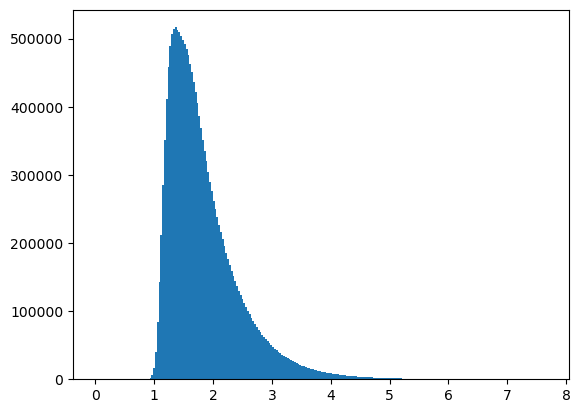

In [11]:
plt.hist(data['bp_rp'], bins=250);

<function matplotlib.pyplot.show(close=None, block=None)>

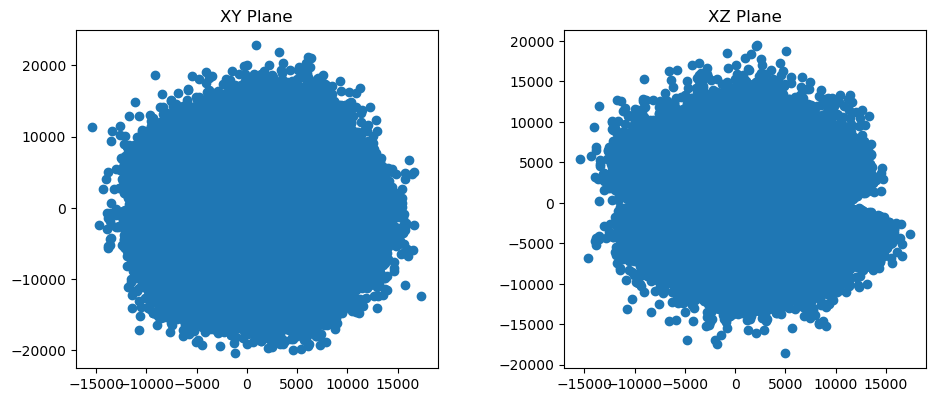

In [12]:
#2D Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].scatter(data['x'], data['y'])
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].scatter(data['x'], data['z'])
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
plt.show

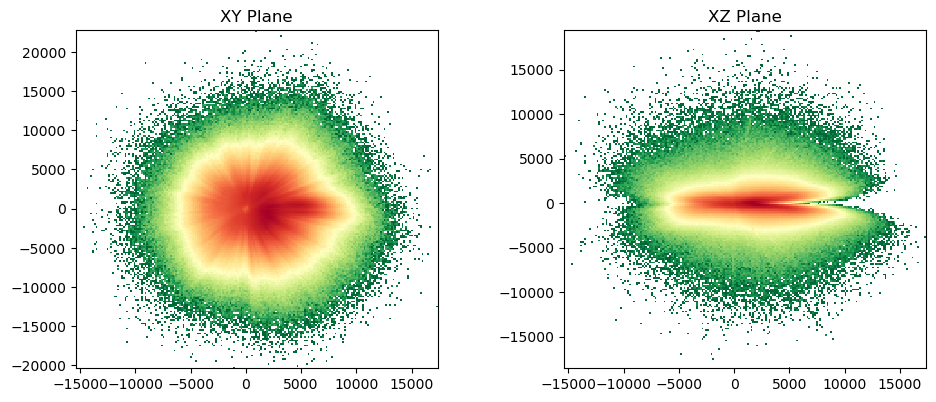

In [13]:
#2D Density Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].hist2d(data['x'], data['y'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].hist2d(data['x'], data['z'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
#plt.show

In [14]:
#construct a speck comment column
data['speck_label'] = data.Column(data=['#__'+str(name) for name in data['source_id']], 
                                  meta=collections.OrderedDict([('ucd', 'meta.id')]),
                                  description='Gaia EDR3 Source ID')

#construct a label column
data['label'] = ['GaiaEDR3_'+ str(source) for source in data['source_id']]  #leaving for now in case we want to add other labels

In [15]:
#setting texture number column
data['texnum'] = data.Column(data=[1]*len(data), 
                                  meta=collections.OrderedDict([('ucd', 'meta.texnum')]),
                                  description='Texture Number')

In [16]:
#Getting the column metadata
columns = file_functions.get_metadata(data, columns=['x', 'y', 'z', 'color', 'lum', 'absmag', 'appmag', 'texnum', 'dist_ly', 'dcalc', 'u', 'v', 'w', 'speed', 'speck_label'])
columns

,name,unit,datatype,width,precision,arraysize,ucd,description
0,x,pc,float64,,6,,pos.cartesian.x,x position (galactic cartesian coordinates) in...
1,y,pc,float64,,6,,pos.cartesian.y,Position (y coordinate) in parsecs
2,z,pc,float64,,6,,pos.cartesian.z,Position (z coordinate) in parsecs
3,color,solLum,float64,,2,,phys.color,Gaia BP-G color
4,lum,solLum,float64,,6,,phys.luminosity,Stellar Luminosity
5,absmag,mag,float64,,6,,phot.magAbs;em.opt.G,Absolute magnitude in Gaia G-band
6,appmag,mag,>f8,,6,,phot.mag;em.opt.G,Apparent magnitude in Gaia G-band
7,texnum,,int32,,,,meta.texnum,Texture Number
8,dist_ly,lyr,float64,,1,,pos.distance,Distance from Sun (lyr)
9,dcalc,,int32,,,,meta.dcalc,Distance Indicator: 1 indicates a Bailer-Jones...


In [29]:
# Print the csv file using the to_csv function in file_functions
file_functions.to_csv(metadata, Table.to_pandas(data), columns)

MemoryError: Unable to allocate 134. MiB for an array with shape (17558141,) and data type >i8

In [ ]:
# Print the speck file using the to_speck function in file_functions
file_functions.to_speck(metadata, Table.to_pandas(data), columns)

MemoryError: Unable to allocate 134. MiB for an array with shape (17558141,) and data type >f8

In [ ]:
# Print the label file using the to_label function in file_functions
file_functions.to_label(metadata, Table.to_pandas(data))